Here we define gobal parameters that are used throughout the analysis

In [1]:
#search_path = '//fwn-nb4-35-5.chem.rug.nl/shared2/SMDM_measurements'
search_path = '//fwn-nb4-35-5.chem.rug.nl/shared2/SMDM_measurements/Dima_data/SMDM/Poles'
#search_path = '//fwn-nb4-35-5.chem.rug.nl/shared2/SMDM_measurements/Luca_and_Wojtek_data'
output_path = 'C:/Users/p262597/Documents/enzymology/smdm/output/dima_data'
#output_path = 'C:/Users/p262597/Documents/enzymology/smdm/output/luca_wojtek_data'


localizations_suffix = ".hdf5"

pixel_size = 100e-3  # in micrometers

min_localizations = 10  # minimum number of localizations for a bin to be represented. Necessary for cell detection

# the following variables are used for filtering out cells
min_cell_displacements = 2000  # minimum number of displacements per cell
max_cell_displacements = 20000 # maximum number of displacements per cell
max_cell_length = 3.0  # maximum cell length in micrometers
min_length = 0.65    # in micrometers
max_width = 1.5      # in micrometers


delta_t = 1.5e-3     # in seconds
r_max = 0.6          # in micrometers
filter_pairs = False # filter out ambiguous displacements
bin_size = 100e-3    # in micrometers

min_displacements = 10   # minimum number of displacements per bin for fitting
initial_D = 1            # initial diffusion coefficients used for fitting
initial_b = 0            # initial background correction for fitting

outlier_correction = True # For Tukey's fences outlier detection 
k_value = 3  # k value for Tukey's fences outlier detection  

intersecting_cells_tolerance = 0.5

The code below scans directories for measurements. A measurements needs to contains three files :
- an hdf5 file that contains all the localizations (this file is generated using the storm analysis package)
- a brightfield image which is used to check if we have localizations in the whole cell
- a drift correction txt file which is used to overlay the localizations with the brightfield

In [21]:
import os

path = os.getcwd()

search_path = path + '/measurements/Dima_data/SMDM/Antibiotics/Rif_good'
#search_path = path + '/measurements/Luca_and_Wojtek_data'

output_path = path + '/measurements/output/antibiotics/rifampicin'
#output_path = path + '/measurements/output/luca'

print("scanning %s for localizations (*%s)..." % (search_path, localizations_suffix))
measurements = []

for root, subFolders, files in os.walk(search_path):
    localization = [os.path.join(root, fn) for fn in files if fn.endswith(localizations_suffix)]
    
    # we assume 1 localizations file per folder
    if len(localization) == 1:
        measurements.append(localization[0])
    elif len(localization) > 1:
        for fname in localization:
            if (fname[-8:-6] != 'p_') and (fname[-10:-5] != 'peaks'):
                measurements.append(fname)
    else:
        continue
    
    print("found measurements : %d\r" % (len(measurements),), end="")

scanning /home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good for localizations (*.hdf5)...


In [22]:
for file in measurements:
    print(file)

/home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good/20221005_no in pad/2/20221005_no in pad_2.hdf5
/home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good/20221005_no in pad/1/20221005_no in pad_1.hdf5
/home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good/20220922_no in pad/2/20220922_2.hdf5
/home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good/20220922_no in pad/1/20220922_1.hdf5


Below we define functions needed for cell detection

In [8]:
import numpy as np
import h5py
import pandas as pd
import scipy.optimize
import scipy.stats
import skimage
import skimage.measure

def read_localizations(path):
    
    # read all the x y coordinates from the hdf5 file
    with h5py.File(path, 'r') as f:
        frames = [int(key[3:]) for key in f.keys() if key.startswith("fr_")]
    
        coordinates = []

        for frame in sorted(frames):
            x = np.array(f["fr_%d" % frame]['x'])
            y = np.array(f["fr_%d" % frame]['y'])
            fr = np.full(x.shape, frame)

            coordinates.extend(np.stack((x, y, fr), axis=-1))

        return np.array(coordinates).T

def create_density_map(x, y, bin_size=1, margin=0):
    xedges = np.arange(np.amin(x) - margin, np.amax(x) + bin_size + margin, bin_size)
    yedges = np.arange(np.amin(y) - margin, np.amax(y) + bin_size + margin, bin_size)
    hist, yedges, xedges = np.histogram2d(y, x, bins=(yedges, xedges), density=True)
    return hist, np.array((xedges[0], xedges[-1], yedges[0], yedges[-1]))

# https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/
def find_orientation(x, y):
    """ find the orientation of all x, y coordinates """
    cov = np.cov(x, y)
    evals, evecs = np.linalg.eig(cov)
    sort_indices = np.argsort(evals)
    x1, y1 = evecs[:, sort_indices[1]]
    
    return np.arctan2(y1, x1)

def rotate(theta, points):
    """ rotates the array of (x,y) points at angle theta (in radians) using rotation matrix """ 
    r = np.array(((np.cos(theta), -np.sin(theta)),
                 (np.sin(theta),  np.cos(theta))))
    return points.dot(r)

def outline_plot(cx, cy, theta, length, width):
    radius = width / 2
    half_length = (length / 2) - radius

    points = []
    points.append((-half_length, radius))

    for rad in np.linspace(0, np.pi, 16):
        points.append((half_length + np.sin(rad) * radius, np.cos(rad) * radius))

    points.append((-half_length, -radius))

    for rad in np.linspace(np.pi, 2 *np.pi, 16):
        points.append((-half_length + np.sin(rad) * radius, np.cos(rad) * radius))
    
    # rotate and translate cell
    return np.transpose(rotate(-theta, np.array(points)) + np.array((cx, cy)))

# https://stackoverflow.com/questions/3349125/circle-circle-intersection-points
def circle_intersection_points(x_n1, y_n1, r1, x_n2, y_n2, r2):

    d = np.sqrt((x_n1 - x_n2)**2 + (y_n1 - y_n2)**2)

    # circles are separate
    if d > (r1 + r2):
        return None
    # circles touches in one single point
    elif d == (r1 + r2):
        return None
    # one circle within the other
    elif d < np.abs(r1 - r2):
        return None
    # circles are coincident
    elif ((d == 0) & (r1 == r2)):
        return None
    else:
        
        a = (r1**2 - r2**2 + d**2)/(2*d)

        h_pos = np.sqrt(r1**2 - a**2)

        p2_x = x_n1 + a*(x_n2 - x_n1)/d
        p2_y = y_n1 + a*(y_n2 - y_n1)/d

        p3_x1 = p2_x + h_pos*(y_n2 - y_n1)/d
        p3_y1 = p2_y - h_pos*(x_n2 - x_n1)/d

        p3_x2 = p2_x - h_pos*(y_n2 - y_n1)/d
        p3_y2 = p2_y + h_pos*(x_n2 - x_n1)/d

        return np.array(((p3_x1, p3_x2), (p3_y1, p3_y2)))
    
def get_cell_intersection(shape1, shape2):
    cx1, cx1, theta1, length1, width1 = shape1
    cx2, cx2, theta2, length2, width2 = shape2
    
    # get poles
    (x11, x12), (y11, y12), _ = get_poles(*shape1)
    (x21, x22), (y21, y22), _ = get_poles(*shape2)
    
    distances = []
    distances.append(np.sqrt(((x11 - x21) ** 2) + ((y11 - y21) ** 2)))
    distances.append(np.sqrt(((x11 - x22) ** 2) + ((y11 - y22) ** 2)))
    distances.append(np.sqrt(((x12 - x21) ** 2) + ((y12 - y21) ** 2)))
    distances.append(np.sqrt(((x12 - x22) ** 2) + ((y12 - y22) ** 2)))
    
    r1, r2 = width1 / 2, width2 / 2
    
    circles = []
    circles.append((x11, y11, r1, x21, y21, r2))
    circles.append((x11, y11, r1, x22, y22, r2))
    circles.append((x12, y12, r1, x21, y21, r2))
    circles.append((x12, y12, r1, x22, y22, r2))
    
    i = np.argmin(distances)
    
    if distances[i] > r1 + r2:
        return None
    
    return circle_intersection_points(*circles[i])

def is_inside(points, x1_line, y1_line, x2_line, y2_line):
    x, y = points.T
    inside = (x - intersection_with_line(y, x1_line, y1_line, x2_line, y2_line)) < 0
    
    if x1_line < 0:
        return ~inside
    
    return inside
    
def inside_cell(x, y, intersection_points, cx, cy, theta, length, width):
    #align along x-axis
    x1, y1 = align_cell(x, y, cx, cy, theta)
    
    # determine the thickness (on z axis) of the cell at location x, y
    radius = width / 2
    half_length = length / 2
    pole = np.abs(x1) > (half_length - radius)
    
    inside = np.abs(y1) < radius
    inside[pole] = np.sqrt(((np.abs(x1[pole]) - (half_length - radius)) ** 2) + (np.abs(y1[pole]) ** 2)) < radius
    
    if intersection_points is not None:
        
        x_1, y_1, x_2, y_2 = intersection_points
            
        points = np.transpose(np.array((x1, y1)))
        inside_2 = is_inside(points, x_1, y_1, x_2, y_2)
        
        inside = inside & inside_2
    
    return inside

def cell_thickness(x, y, cx, cy, theta, length, width):
    # orient the cell along the x-axis
    
    # rotation matrix
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    
    # translate and rotate
    x1, y1 = np.transpose((x - cx, y - cy)).dot(R).T

    # determine the probability density of a point to be in the cell, assuming points are uniformly distributed
    # then the probability density only depend on the thickness (z value) of the point
    
    # determine the thickness (on z axis) of the cell at location x, y
    radius = width / 2
    half_length = length / 2
    pole = np.abs(x1) > (half_length - radius)
    
    # distance to the cell middle (up to radius)
    distance = np.abs(y1)
    distance[pole] = np.sqrt(((np.abs(x1[pole]) - (half_length - radius)) ** 2) + (np.abs(y1[pole]) ** 2))
    
    # from the distance determine what the thickness is
    half_thickness_sq = (radius ** 2) - (distance ** 2)
    half_thickness_sq[half_thickness_sq < 0] = 0
    thickness = np.sqrt(half_thickness_sq) * 2
    
    return thickness

def likelihood_noise(x, y, cx, cy, theta, length, width):

    thickness = cell_thickness(x, y, cx, cy, theta, length, width)

    # volume of the spherocylinder
    volume = (((width / 2) ** 2) * np.pi * (length - width)) + ((4 / 3) * np.pi * ((width / 2) ** 3))

    # thickness to probability density
    density = thickness / volume
    
    # probability of noise: the probability of a point being noise is the same for all points.
    # That means that each point has a probability of 1/N to be noise (N number of points)
    noise = 1 / len(thickness)
    density += noise
    density /= 2 #--> to divide the pdf so that final probability is 1
    
    return np.sum(np.log(density))

def likelihood_noise_2(x, y, cx1, cy1, theta1, length1, width1, cx2, cy2, theta2, length2, width2):
    """ Same function as likelihood_noise but now for two cells """
    
    thickness1 = cell_thickness(x, y, cx1, cy1, theta1, length1, width1)
    thickness2 = cell_thickness(x, y, cx2, cy2, theta2, length2, width2)
    
    # volume of the spherocylinder
    volume1 = (((width1 / 2) ** 2) * np.pi * (length1 - width1)) + ((4 / 3) * np.pi * ((width1 / 2) ** 3))
    volume2 = (((width2 / 2) ** 2) * np.pi * (length2 - width2)) + ((4 / 3) * np.pi * ((width2 / 2) ** 3))
    
    # find density of intersection
    shape1 = [cx1, cy1, theta1, length1, width1]
    shape2 = [cx2, cy2, theta2, length2, width2]
    intersection = get_cell_intersection(shape1, shape2)
    
    if intersection is not None:
        
        intersection_x, intersection_y = intersection
        x_1, x_2 = intersection_x
        y_1, y_2 = intersection_y
        intersection_points = (x_1, y_1, x_2, y_2)
        
        # length of intersection segment
        a = np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2)

        # height of intersection segments
        h_1 = width1/2 - np.sqrt((width1/2)**2 - (a/2)**2)
        h_2 = width2/2 - np.sqrt((width2/2)**2 - (a/2)**2)

        # volumes of intersection segments
        v_1 = np.pi*h_1*(3*(a**2) + h_1**2)/6
        v_2 = np.pi*h_2*(3*(a**2) + h_2**2)/6
        v_int = v_1 + v_2
        
        # combine probabilities together
        density = (thickness1 + thickness2)/(volume1 + volume2 + v_int)
        
    else:
        
        density = (thickness1 + thickness2)/(volume1 + volume2)
    
    noise = 1 / len(x)
    density += noise
    density /= 2
    
    return np.sum(np.log(density))

def is_dividing(x, y, length, width):
    """ divide cell into three regions (excluding the pole regions). If the center region has less localizations compared to the left and right regions the cell is most likely dividing. """
    p_left = -(length - width) / 2
    p_left_center = -(length - width) / 6
    p_right_center =  (length - width) / 6
    p_right = (length - width) / 2
    
    left_region = (x >= p_left) & (x < p_left_center)
    center_region = (x >= p_left_center) & (x < p_right_center)
    right_region = (x >= p_right_center) & (x < p_right)
    
    n_left_region = np.count_nonzero(left_region)
    n_center_region = np.count_nonzero(center_region)
    n_right_region = np.count_nonzero(right_region)
    
    return n_center_region < n_left_region and n_center_region < n_right_region


def align_cell(x, y, cx, cy, theta):
    # rotation matrix
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    
    # translate and rotate
    return np.transpose((x - cx, y - cy)).dot(R).T

def get_poles(cx, cy, theta, length, width):
    dx = np.cos(theta) * ((length - width) / 2)
    dy = np.sin(theta) * ((length - width) / 2)
    return np.array((cx - dx, cx + dx)), np.array((cy - dy, cy + dy)), np.array((width / 2, width / 2))

def is_overlapping(shape1, shape2):
    x_p1, y_p1, r_p1 = get_poles(*shape1)
    x_p2, y_p2, r_p2 = get_poles(*shape2)
    
    # create distance matrix
    x_from, x_to = np.meshgrid(x_p1, x_p2)
    y_from, y_to = np.meshgrid(y_p1, y_p2)
    r = np.sqrt(((x_to - x_from) ** 2) + ((y_to - y_from) ** 2)).T
    
    # left or right pole ?
    left_is_closest = np.array(np.unravel_index(r.argmin(), r.shape)) == 0
    
    return (r < (r_p1 + r_p2) * intersecting_cells_tolerance).any(), left_is_closest

def any_overlap(shape, cell_shapes):
    for shape2 in cell_shapes:
        if not np.array_equal(shape, shape2):
            overlapping, _ = is_overlapping(shape, shape2)
            if overlapping:
                return True
    return False
   
def detect_cells_threshold(x, y):
    """ Threshold the density map to find cells and then fit each cell with a density model using maximum likelihood estimation """
    
    # create a density map of the localization data to label all cells
    hist, extent = create_density_map(x, y, 1, margin=5)

    # the threshold is determined by 1 standard deviation above the background value. The median value is taken as the background value.
    threshold = np.median(hist) + np.std(hist)
    im_labels = skimage.measure.label(hist > threshold)

    # for each x, y localization we determine to which cell it belongs (label each localization)
    label = im_labels[(y - extent[2]).astype(int), (x - extent[0]).astype(int)]
    
    # remove cells that are too small
    cells, counts = np.unique(label, return_counts=True)
    cells = cells[(cells > 0) & (counts > min_localizations)] # only consider these labels; label 0 is the background and can therefor be discarded

    # determine the initial cell shape and fit each cell
    initial_cell_shapes = []
    fitted_cell_shapes = []
    cell_poles = []
    intersection_points = []
    
    for cell in cells:
        x_unaligned = x[label == cell].copy()
        y_unaligned = y[label == cell].copy()
        
        # cell orientation/angle
        theta = find_orientation(x_unaligned, y_unaligned)
        
        # cell center
        cx = (np.amin(x_unaligned) + np.amax(x_unaligned)) / 2
        cy = (np.amin(y_unaligned) + np.amax(y_unaligned)) / 2

        # align cell with the x_axis by translating and rotating each point
        points = np.transpose((x_unaligned, y_unaligned)) - (cx, cy)
        points = rotate(theta, points)
        
        # take the bounding box of all points as an estimate of the cell's length/width
        x_aligned, y_aligned = points.T
        
        length = np.amax(x_aligned) - np.amin(x_aligned)
        width = np.amax(y_aligned) - np.amin(y_aligned)
        
        # a check to avoid noise or unwanted fluorescence spots
        if length * pixel_size < min_length or width * pixel_size > max_width:
            continue

        initial_guess = (cx, cy, theta, length, width)
        initial_cell_shapes.append(initial_guess)
        
        f = lambda parameters: -likelihood_noise(x_unaligned, y_unaligned, *parameters)
        res = scipy.optimize.minimize(f, initial_guess, method='Nelder-Mead')
        fitted_shape = res.x
        
        cx, cy, theta, length, width = fitted_shape
        
        # check for cell division
        if length * pixel_size > max_cell_length and is_dividing(x_aligned, y_aligned, length, width):
            
            # routine for fitting two different cells in the same FOV
            # chop cell in two
            cx, cy, theta, length, width = initial_guess

            cx1 = cx - 0.25 * length * np.cos(theta)
            cy1 = cy - 0.25 * length * np.sin(theta)
            cx2 = cx + 0.25 * length * np.cos(theta)
            cy2 = cy + 0.25 * length * np.sin(theta)
            
            initial_guess2 = (cx1, cy1, theta, length / 2, width, cx2, cy2, theta, length / 2, width)
        
            f = lambda parameters: -(likelihood_noise_2(x_unaligned, y_unaligned, *parameters))
            res = scipy.optimize.minimize(f, initial_guess2, method='Nelder-Mead')
            fitted_shapes = res.x
            fitted_shape_1 = fitted_shapes[:5]
            fitted_shape_2 = fitted_shapes[5:]
            
            # check if fitted cells are an improvement over 1 cell fit
            # TODO
            
            fitted_cell_shapes.append(fitted_shape_1)
            fitted_cell_shapes.append(fitted_shape_2)
            
            # determine old- and new pole --> if left is new, then it is true
            # if left pole of cell 1 is new pole, then pole1 will be true, pole2 will be false
            _, (pole1, pole2) = is_overlapping(fitted_shape_1, fitted_shape_2)
            
            cell_poles.append(pole1)
            cell_poles.append(pole2)
            
            # check intersection between the two poles
            intersection = get_cell_intersection(fitted_shape_1, fitted_shape_2)

            if intersection is not None:
                points1 = intersection.T  # to x y coordinates
                points1 = rotate(fitted_shape_1[2], points1 - np.array((fitted_shape_1[0], fitted_shape_1[1])))

                points2 = intersection.T  # to x y coordinates
                points2 = rotate(fitted_shape_2[2], points2 - np.array((fitted_shape_2[0], fitted_shape_2[1])))

                intersection_points_1 = (points1[0][0], points1[0][1], points1[1][0], points1[1][1])
                intersection_points_2 = (points2[0][0], points2[0][1], points2[1][0], points2[1][1])
            
                intersection_points.append(intersection_points_1)
                intersection_points.append(intersection_points_2)
            
        else:
            fitted_cell_shapes.append(fitted_shape)
            cell_poles.append(None)
            intersection_points.append(None)
    
    # keep angle between 0 and 2*pi
    corrected_fitted_cell_shapes = []
    for cx, cy, theta, length, width in fitted_cell_shapes:
        while theta < 0:
            theta += 2 * np.pi
        while theta >= 2 * np.pi:
            theta -= 2 * np.pi
        corrected_fitted_cell_shapes.append((cx, cy, theta, length, width))    
    fitted_cell_shapes = corrected_fitted_cell_shapes
    #
    
    return initial_cell_shapes, fitted_cell_shapes, cell_poles, intersection_points

def intersection_with_line(y_point, x1_line, y1_line, x2_line, y2_line):
    dx, dy = x2_line - x1_line, y2_line - y1_line
    m = dx / dy
    return m * (y_point - y1_line) + x1_line

def get_displacements(x, y, frame, filter_pairs=False):
    displacements = []
    
    for fr in range(0, int(np.max(frame)), 2):
        
        first = (frame == fr)
        second = (frame == (fr + 1))
        
        x1, y1, x2, y2 = x[first], y[first], x[second], y[second]
        
        # calculate a distance matrix
        x_from, x_to = np.meshgrid(x1, x2)
        y_from, y_to = np.meshgrid(y1, y2)
        r = np.sqrt(((x_to - x_from) ** 2) + ((y_to - y_from) ** 2))
        
        # check which coordinates are within r_max distance
        connected = r <= (r_max / pixel_size)
        valid = connected
        
        if filter_pairs:
            # make sure each coordinate is linked to exactly one other coordinate
            single_from = np.sum(connected, axis=0) == 1
            single_to = np.sum(connected, axis=1) == 1
            valid = connected & np.logical_and(*np.meshgrid(single_from, single_to))

        pairs = np.array((x_from[valid], y_from[valid], x_to[valid], y_to[valid], r[valid])).T
        displacements.extend(pairs)
        
    return np.array(displacements).T

In [9]:
'''THIS PIECE OF CODE TAKES LONG, RUN IT ONLY ONCE IF YOU ARE TESTING'''

# change this line to analyze an other measurement
localizations_path = measurements[0]

x, y, frame = read_localizations(localizations_path)

In [10]:
im_density, extent_density = create_density_map(x, y)
initial_cell_shapes, cell_shapes, cell_poles, intersection_points = detect_cells_threshold(x, y)

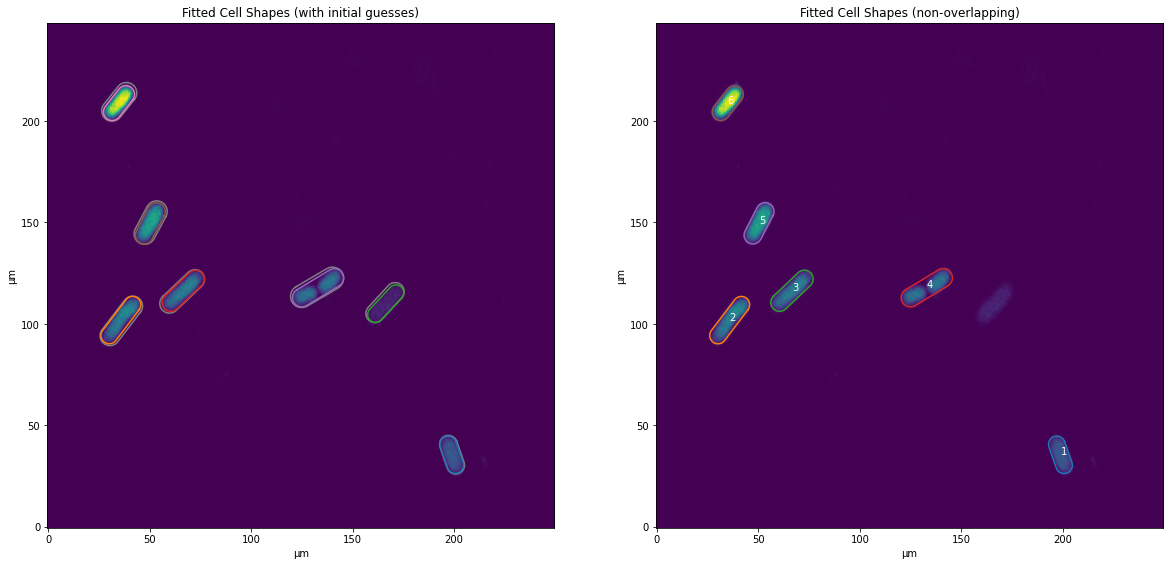

White points are new poles, red points are old poles


In [11]:
import matplotlib.pyplot as plt

# code for testing cell detection

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(im_density, origin="lower", extent=extent_density)
axes[1].imshow(im_density, origin="lower", extent=extent_density)

for initial_cell_shape in initial_cell_shapes:
    axes[0].plot(*outline_plot(*initial_cell_shape), c="grey")

filtered_cell_shapes = []
filtered_cell_poles = []

for cell_shape, left_is_new in zip(cell_shapes, cell_poles):
    axes[0].plot(*outline_plot(*cell_shape))
    if not any_overlap(cell_shape, cell_shapes) and cell_shape[3] * pixel_size <= max_cell_length:
        filtered_cell_shapes.append(cell_shape)
        filtered_cell_poles.append(left_is_new)
        
# only keep cell shapes that are non-overlapping
cell_shapes = filtered_cell_shapes
cell_poles = filtered_cell_poles

# code for testing cell displacements
x0, y0, x1, y1, r = get_displacements(x, y, frame, filter_pairs=False)

# filter out cell with too little or too many displacements
filtered_cell_shapes = []
filtered_cell_poles = []
filtered_intersection_points = []

for cell_shape, left_is_new, intersection in zip(cell_shapes, cell_poles, intersection_points):
    inside = inside_cell(x0, y0, intersection, *cell_shape)
    
    if min_cell_displacements <= np.count_nonzero(inside) <= max_cell_displacements:  
        filtered_cell_shapes.append(cell_shape)
        filtered_cell_poles.append(left_is_new)
        filtered_intersection_points.append(intersection)

cell_shapes = filtered_cell_shapes
cell_poles = filtered_cell_poles
intersection_points = filtered_intersection_points

for i, cell_shape in enumerate(cell_shapes):
    axes[1].plot(*outline_plot(*cell_shape))
    axes[1].text(cell_shape[0], cell_shape[1], "%d" % (i + 1), c="white")
    
for cell_shape, left_is_new in zip(cell_shapes, cell_poles):
    if left_is_new != None:
        (x_p1, x_p2), (y_p1, y_p2), _ = get_poles(*cell_shape)
        axes[1].scatter((x_p1), (y_p1), c="white" if left_is_new else "red")
        axes[1].scatter((x_p2), (y_p2), c="red" if left_is_new else "white")
    
    
axes[0].set_xlabel("μm")
axes[0].set_ylabel("μm")
axes[0].set_title("Fitted Cell Shapes (with initial guesses)")

axes[1].set_xlabel("μm")
axes[1].set_ylabel("μm")
axes[1].set_title("Fitted Cell Shapes (non-overlapping)")

plt.show()

print("White points are new poles, red points are old poles")

The following functions are needed for pairing localizations in order to get displacements

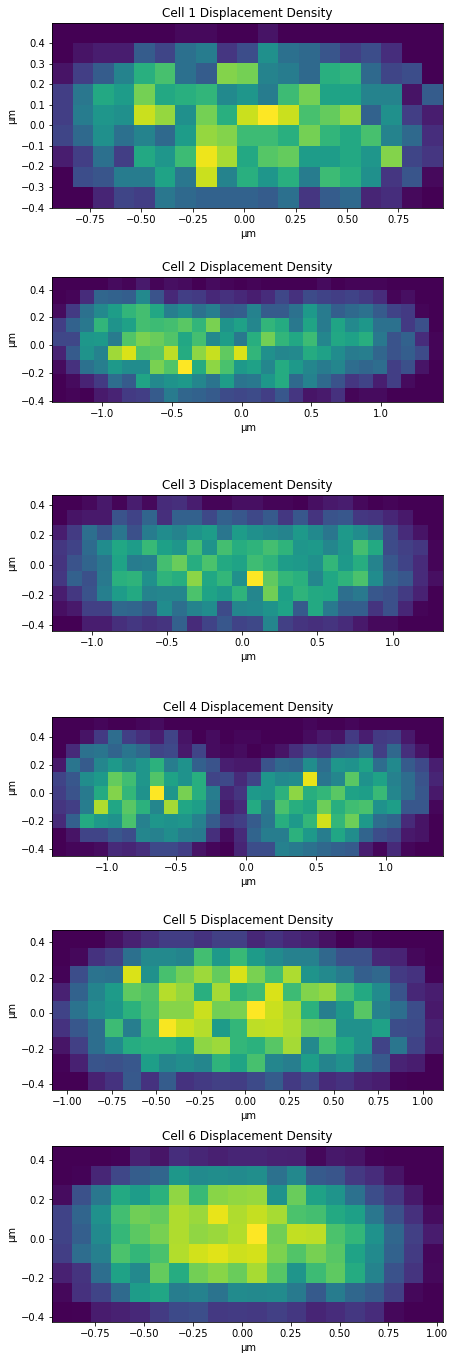

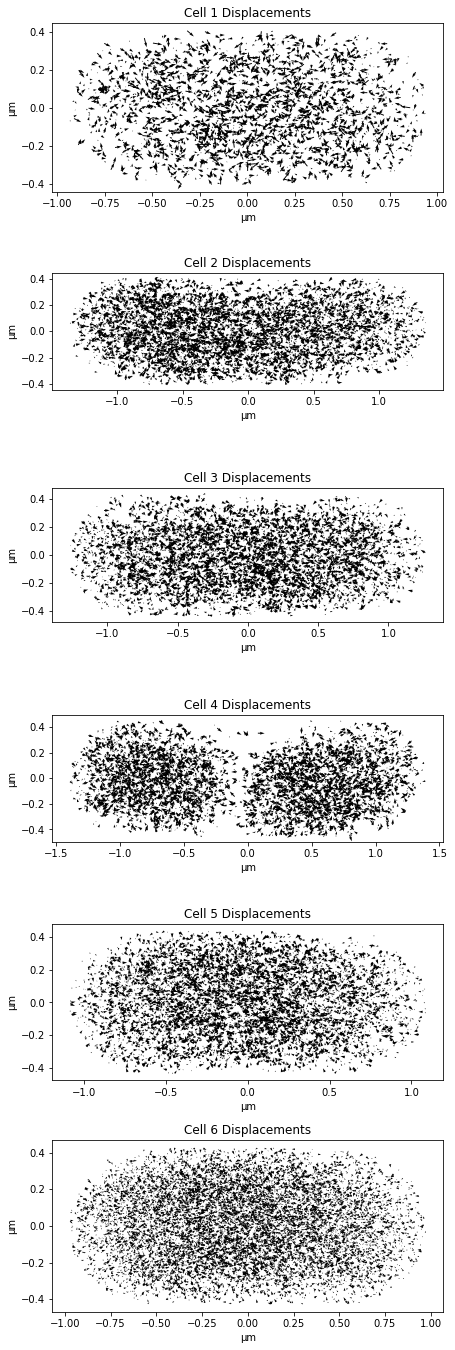

In [12]:
if len(cell_shapes) > 0:
    
    fig, axes = plt.subplots(squeeze=False, nrows=len(cell_shapes), ncols=1, figsize=(7,4*len(cell_shapes)))

    for i, (cx, cy, theta, length, width) in enumerate(cell_shapes):
        inside = inside_cell(x0, y0, intersection_points[i], cx, cy, theta, length, width)
        x_aligned, y_aligned = align_cell(x0[inside], y0[inside], cx, cy, theta)
        im_density, extent_density = create_density_map(x_aligned, y_aligned)
        axes[i,0].imshow(im_density, origin="lower", extent=extent_density * pixel_size)
        if intersection_points[i] is not None:
            axes[i,0].scatter(intersection_points[i][0]*pixel_size, intersection_points[i][1]*pixel_size, color = 'red')
            axes[i,0].scatter(intersection_points[i][2]*pixel_size, intersection_points[i][3]*pixel_size, color = 'red')
            axes[i,0].plot([intersection_points[i][0]*pixel_size, intersection_points[i][2]*pixel_size], [intersection_points[i][1]*pixel_size, intersection_points[i][3]*pixel_size], color = 'red')
        axes[i,0].set_xlabel("μm")
        axes[i,0].set_ylabel("μm")
        axes[i,0].set_title("Cell %d Displacement Density" % (i + 1))
    plt.show()  

    fig, axes = plt.subplots(squeeze=False, nrows=len(cell_shapes), ncols=1, figsize=(7,4*len(cell_shapes)))

    for i, (cx, cy, theta, length, width) in enumerate(cell_shapes):
        inside = inside_cell(x0, y0, intersection_points[i], cx, cy, theta, length, width)
        x0_aligned, y0_aligned = align_cell(x0[inside], y0[inside], cx, cy, theta)
        x1_aligned, y1_aligned = align_cell(x1[inside], y1[inside], cx, cy, theta)
        axes[i,0].quiver(x0_aligned * pixel_size, y0_aligned * pixel_size, (x1_aligned - x0_aligned) * pixel_size, (y1_aligned - y0_aligned) * pixel_size, linewidth=0.5)
        if intersection_points[i] is not None:
            axes[i,0].scatter(intersection_points[i][0]*pixel_size, intersection_points[i][1]*pixel_size, color = 'red')
            axes[i,0].scatter(intersection_points[i][2]*pixel_size, intersection_points[i][3]*pixel_size, color = 'red')
            axes[i,0].plot([intersection_points[i][0]*pixel_size, intersection_points[i][2]*pixel_size], [intersection_points[i][1]*pixel_size, intersection_points[i][3]*pixel_size], color = 'red')
        axes[i,0].set_aspect('equal')
        axes[i,0].set_xlabel("μm")
        axes[i,0].set_ylabel("μm")
        axes[i,0].set_title("Cell %d Displacements" % (i + 1))
        
    plt.show()

Using the following probability density function (pdf) based on Rayleigh distribution: 

$$ P(r,a)=\frac{2r}{a}e^{-\frac{r^2}{a}} $$

where $a=4\Delta t D$ and displacements $r$ we can use maximum-likelihood estimation to find diffusion coefficient $D$.

Some displacements originate from noise. The probability density of such displacements should be added to the probability density function (pdf) as a linear summation $br$.

$$  P(r,a)=\frac{2r}{a}e^{-\frac{r^2}{a}}+br $$

When b is a positive, non zero, number the total total probability density will exceed 1.0. Also, when restricting $r_{max}$, the total density at $r_{max}$ may be lower than 1.0. Since we consider displacements limited by $r_{max}$, $P(r,a,b)$ should be normalized by $\int_{0}^{r_{max}} P(r,a,b)\,dx$.

$$ \int_{0}^{r_{max}} \frac{2r}{a}e^{-\frac{r^2}{a}}+br \,dx = \int_{0}^{r_{max}} \frac{2r}{a}e^{-\frac{r^2}{a}} \,dx +\int_{0}^{r_{max}} br \,dx = 1 - e^{-\frac{r_{max}^2}{a}} + \frac{r_{max}^2b}{2}$$


Since the total probability density is 1 the normalized probability density fuction can be written as:

$$ P(r,a,b)=\frac{\frac{2r}{a}e^{-\frac{r^2}{a}}+br}{1 - e^{-\frac{r_{max}^2}{a}}+ \frac{r_{max}^2b}{2}} $$

In [13]:
import scipy.optimize

def pdf(r, r_max, delta_t, D, b):
    a = 4 * delta_t * D
    density = ((2 * r) / a) * np.exp(-(r ** 2) / a) + (b * r)
    normalization = (1 - np.exp(-(r_max ** 2) / a)) + ((r_max ** 2) * b) / 2
    return density / normalization


def likelihood(r, r_max, delta_t, D, b):
    return np.sum(np.log(pdf(r, r_max, delta_t, D, b)))
    
def minimization_function(x, *args):
    D, b = x
    r, r_max, delta_t = args
    return -likelihood(r, r_max, delta_t, D, b)

def maximum_likelihood(r, r_max, delta_t, D, b=0):
    """
    Calculating parameters of the distribution (Diffusion coefficient and background correction coefficient)
    Maximum of the likelihood function is evaluated by minimization of - likelihood function "minimization_function(x, *args)"
    """
    
    bounds = [(1e-6, None), (0, None)]
    initial = (D, b)
    
    res = scipy.optimize.minimize(minimization_function, initial, (r, r_max, delta_t), method='Nelder-Mead', bounds=bounds)
    
    return res.x


class Binning2d:
    """
        This class bins the data by taking all displacements that lie within a given rectangle (x0, y0, x1, y1).
        The class also contains methods to get the minimum and maximum coordinates (get_bounds) and to get a grid of bins (get_bins).
        
        The get_bins method takes an area (x0, y0, x1, y1) and a pixel size (bin_width) and returns a matrix where each column consists of a list of displacements
        (i.e. the upper left column contains a list of displacements that start on a coordinate that falls within (x0, y0, x0 + bin_width, y0 + bin_width)) .
    """
    def __init__(self, x, y, data):
        self.data = data
        self.x = x
        self.y = y
        self.x_indices = np.argsort(self.x)
        self.y_indices = np.argsort(self.y)
        self.x_values_sorted = np.sort(self.x)
        self.y_values_sorted = np.sort(self.y)
    
    def get_data(self, x0, y0, x1, y1):
        x_left = np.searchsorted(self.x_values_sorted, x0, side="left")
        x_right = np.searchsorted(self.x_values_sorted, x1, side="right")
        y_left = np.searchsorted(self.y_values_sorted, y0, side="left")
        y_right = np.searchsorted(self.y_values_sorted, y1, side="right")
        
        indices = np.intersect1d(self.x_indices[x_left:x_right], self.y_indices[y_left:y_right])
        return self.x[indices], self.y[indices], self.data[indices]
    
    def get_bounds(self):
        x_min, x_max = self.x_values_sorted[0], self.x_values_sorted[-1]
        y_min, y_max = self.y_values_sorted[0], self.y_values_sorted[-1]
        return x_min, y_min, x_max, y_max

    def get_bins(self, x0, y0, ncols, nrows, bin_size):
        
        rows = []
        for y in np.arange(nrows):
            y_bin = y0 + y * bin_size
            cols = []
            for x in np.arange(ncols):
                x_bin = x0 + x * bin_size
                cols.append(self.get_data(x_bin, y_bin, x_bin + bin_size, y_bin + bin_size))
            rows.append(cols)
        return rows



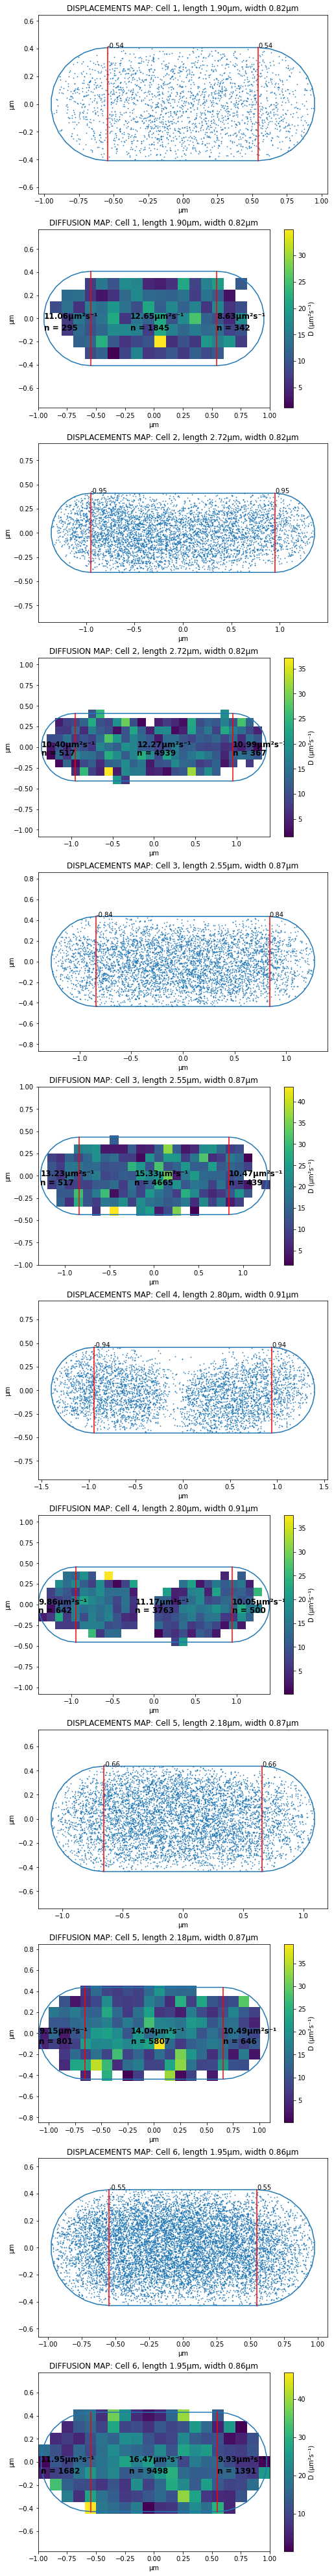

In [14]:
#x0, y0, x1, y1, r = get_displacements(x, y, frame, filter_pairs=False)

if len(cell_shapes) > 0:

    table = []
    fig, axes = plt.subplots(squeeze=False, nrows=2*len(cell_shapes), figsize=(8,1.5*8 * len(cell_shapes)))

    for i, (cx, cy, theta, length, width) in enumerate(cell_shapes):

        inside = inside_cell(x0, y0, intersection_points[i], cx, cy, theta, length, width)

        x_aligned, y_aligned = align_cell(x0[inside], y0[inside], cx, cy, theta) * pixel_size

        # calculate the number of columns and rows of the resulting diffusion map
        ncols, nrows = int(np.ceil(np.ceil((length * pixel_size) / bin_size))), int(np.ceil(np.ceil((width * pixel_size) / bin_size)))
        binning = Binning2d(x_aligned, y_aligned, r[inside])
        bins = binning.get_bins(-(ncols * bin_size) / 2, -(nrows * bin_size) / 2, ncols, nrows, bin_size=bin_size)

        x_from, y_from = -(ncols * bin_size) / 2, -(nrows * bin_size) / 2
        x_to, y_to = (ncols * bin_size) / 2, (nrows * bin_size) / 2
        extent = x_from, x_to, y_from, y_to

        # fit all displacements per bin
        diffusion_map = np.full((nrows, ncols), np.nan)
        background_map = np.full((nrows, ncols), np.nan)

        for j, row in enumerate(bins):
            for k, (_, _, displacements) in enumerate(row):

                if len(displacements) > min_displacements:
                    D, b = maximum_likelihood(np.array(displacements) * pixel_size, r_max, delta_t, initial_D, initial_b)
                    diffusion_map[j, k] = D
                    background_map[j, k] = b


        if outlier_correction:
            lower_boundary = np.nanquantile(diffusion_map, 0.25) - k_value * (np.nanquantile(diffusion_map, 0.75) - np.nanquantile(diffusion_map, 0.25))
            upper_boundary = np.nanquantile(diffusion_map, 0.75) + k_value * (np.nanquantile(diffusion_map, 0.75) - np.nanquantile(diffusion_map, 0.25))

            diffusion_map = np.where((diffusion_map < lower_boundary) | (diffusion_map > upper_boundary), np.nanmedian(diffusion_map), diffusion_map)                         

        x_left = -length / 2
        x_right = length / 2
        x_left_pole = x_left + width / 2
        x_right_pole = x_right - width / 2

        # check if intersection is on right or left:
        if intersection_points[i] is not None:

            x_1, y_1, x_2, y_2 = intersection_points[i]

            # determine left pole and right pole
            x_intersection = intersection_with_line(0, x_1, y_1, x_2, y_2)

            if ((x_intersection < 0) and (x_left < x_intersection)):
                x_left_pole = x_intersection + (width / 2)
            if ((x_intersection > 0) and (x_right > x_intersection)):
                x_right_pole = x_intersection - (width / 2)

        left_pole = x_aligned < (x_left_pole*pixel_size)
        right_pole = x_aligned > (x_right_pole*pixel_size)
        center = ~(left_pole | right_pole)
        r_cell = r[inside]

        D_left, b_left = maximum_likelihood(np.array(r_cell[left_pole]) * pixel_size, r_max, delta_t, initial_D, initial_b)
        D_center, b_center = maximum_likelihood(np.array(r_cell[center]) * pixel_size, r_max, delta_t, initial_D, initial_b)
        D_right, b_right = maximum_likelihood(np.array(r_cell[right_pole]) * pixel_size, r_max, delta_t, initial_D, initial_b)

        n_left = np.count_nonzero(left_pole)
        n_center = np.count_nonzero(center)
        n_right = np.count_nonzero(right_pole)

        # plotting
        alpha = int(2*i)
        beta = int(2*i + 1)
        D_unit = "\u03BCm\u00B2s\u207B\u00B9"
        length = length*pixel_size
        width = width*pixel_size

        axes[alpha,0].plot(*outline_plot(0, 0, 0, length, width))
        axes[alpha,0].scatter(x_aligned, y_aligned, s = 0.5)
        if intersection_points[i] is not None:
            int_x1 = x_1*pixel_size
            int_y1 = y_1*pixel_size
            int_x2 = x_2*pixel_size
            int_y2 = y_2*pixel_size
            intersection_points[i] = np.array((int_x1, int_y1, int_x2, int_y2))
            axes[alpha,0].scatter(intersection_points[i][0], intersection_points[i][1], color = 'r')
            axes[alpha,0].scatter(intersection_points[i][2], intersection_points[i][3], color = 'r')
            axes[alpha,0].plot([intersection_points[i][0], intersection_points[i][2]], [intersection_points[i][1], intersection_points[i][3]], color = 'r')
            axes[alpha,0].text(int_x1, int_y1, "%.2f, %.2f" % (int_x1, int_y1))
            axes[alpha,0].text(int_x2, int_y2, "%.2f, %.2f" % (int_x2, int_y2))

        left = x_left_pole*pixel_size
        right = x_right_pole*pixel_size

        axes[alpha,0].plot((left, left), (-width/2, width/2), color = 'r')
        axes[alpha,0].plot((right, right), (-width/2, width/2), color = 'r')
        axes[alpha,0].text(left, width/2, "%.2f" % left)
        axes[alpha,0].text(right, width/2, "%.2f" % right)
        axes[alpha,0].set_xlabel("\u03BCm")
        axes[alpha,0].set_ylabel("\u03BCm")
        axes[alpha,0].axis('equal')
        axes[alpha,0].set_title("DISPLACEMENTS MAP: Cell %d, length %.2f\u03BCm, width %.2f\u03BCm" % (i + 1, length, width))

        pos = axes[beta,0].imshow(diffusion_map, origin="lower", extent=extent)
        axes[beta,0].plot(*outline_plot(0, 0, 0, length, width))
        if intersection_points[i] is not None:
            int_x1 = x_1*pixel_size
            int_y1 = y_1*pixel_size
            int_x2 = x_2*pixel_size
            int_y2 = y_2*pixel_size
            intersection_points[i] = np.array((int_x1, int_y1, int_x2, int_y2))
            axes[beta,0].scatter(intersection_points[i][0], intersection_points[i][1], color = 'r')
            axes[beta,0].scatter(intersection_points[i][2], intersection_points[i][3], color = 'r')
            axes[beta,0].plot([intersection_points[i][0], intersection_points[i][2]], [intersection_points[i][1], intersection_points[i][3]], color = 'r')
        axes[beta,0].plot((left, left), (-width/2, width/2), color = 'r')
        axes[beta,0].plot((right, right), (-width/2, width/2), color = 'r')
        axes[beta,0].text(-length/2, 0, "%.2f%s" % (D_left, D_unit), size="large", weight="bold")
        axes[beta,0].text(-width/4, 0, "%.2f%s" % (D_center, D_unit), size="large", weight="bold")
        axes[beta,0].text(right, 0, "%.2f%s" % (D_right, D_unit), size="large", weight="bold")
        axes[beta,0].text(-length/2, -0.1, 'n = ' + str(n_left), size="large", weight="bold")
        axes[beta,0].text(-width/4, -0.1, 'n = ' + str(n_center), size="large", weight="bold")
        axes[beta,0].text(right, -0.1, 'n = ' + str(n_right), size="large", weight="bold")
        axes[beta,0].set_xlabel("\u03BCm")
        axes[beta,0].set_ylabel("\u03BCm")
        axes[beta,0].axis('equal')
        axes[beta,0].set_title("DIFFUSION MAP: Cell %d, length %.2f\u03BCm, width %.2f\u03BCm" % (i + 1, length, width))
        fig.colorbar(pos, ax=axes[beta,0], label = 'D (' + D_unit + ')')

        displacements_str = " ".join(diffusion_map.ravel().astype(str))
        background_str = " ".join(background_map.ravel().astype(str))
        x_start_str = " ".join(x_aligned.astype(str))
        y_start_str = " ".join(y_aligned.astype(str))
        r_str = " ".join(r_cell.astype(str))
        if intersection_points[i] is not None:
            intersection_str = " ".join(intersection_points[i].astype(str))
        else:
            intersection_str = 'None'

        table.append((cx, cy, theta, D_left, b_left, n_left, D_center, b_center, n_center, D_right, b_right, n_right, length, width, bin_size, x_from, y_from, ncols, nrows, x_start_str, y_start_str, r_str, cell_poles[i], left, right, intersection_str, displacements_str, background_str))

    plt.show()
    
else:
    
    print('no cells detected')

In [15]:
# save all data
measurement_name = os.path.basename(localizations_path)[:-5]
csv_name = measurement_name + ".csv"

header = ["cx", "cy", "angle", "D_left", "b_left", "n_left", "D_center", "b_center", "n_center", "D_right", "b_right", "n_right", "length", "width", "bin_size", "x0", "y0", "ncols", "nrows", "x_start", "y_start", "r", "left_is_new_pole", "x_left_pole", "x_right_pole", "intersection_points", "displacements", "background"]

if len(cell_shapes) > 0:

    with open(os.path.join(output_path, csv_name), "w") as f:
        f.write("sep=,\n" + ",".join(header) + "\n")
        for row in table:
            f.write(",".join(np.array(row).astype(str)) + "\n")

    print("done")

done


The following block combines all steps into one function that performs the whole analysis

In [23]:
import warnings

# ignore warnings caused by invalid values encountered in sqrt or log during the fitting routine
warnings.filterwarnings("ignore", category=RuntimeWarning)

for index, localizations_path in enumerate(measurements):
    
    try:
        print("(%d/%d) %s" % (index + 1, len(measurements), localizations_path))

        # determine the base name for the output files
        measurement_name = os.path.basename(localizations_path)[:-5]

        # determine cell shapes
        x, y, frame = read_localizations(localizations_path)
        im_density, extent_density = create_density_map(x, y)
        initial_cell_shapes, cell_shapes, cell_poles, intersection_points = detect_cells_threshold(x, y)
        
        fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
        axes[0].imshow(im_density, origin="lower", extent=extent_density)
        axes[1].imshow(im_density, origin="lower", extent=extent_density)

        for initial_cell_shape in initial_cell_shapes:
            axes[0].plot(*outline_plot(*initial_cell_shape), c="grey")
        
        # filtering of cells
        filtered_cell_shapes = []
        filtered_cell_poles = []
        
        initial_cells = len(cell_shapes)

        for cell_shape, left_is_new in zip(cell_shapes, cell_poles):
            axes[0].plot(*outline_plot(*cell_shape))
            if not any_overlap(cell_shape, cell_shapes) and cell_shape[3] * pixel_size <= max_cell_length:
                filtered_cell_shapes.append(cell_shape)
                filtered_cell_poles.append(left_is_new)

        # only keep cell shapes that are non-overlapping
        wrong_cell_shape = initial_cells - len(filtered_cell_shapes)
        cell_shapes = filtered_cell_shapes
        cell_poles = filtered_cell_poles

        # code for testing cell displacements
        x0, y0, x1, y1, r = get_displacements(x, y, frame, filter_pairs=False)

        # filter out cell with too little or too many displacements
        filtered_cell_shapes = []
        filtered_cell_poles = []
        filtered_intersection_points = []

        for cell_shape, left_is_new, intersection in zip(cell_shapes, cell_poles, intersection_points):
            inside = inside_cell(x0, y0, intersection, *cell_shape)
            
            if min_cell_displacements <= np.count_nonzero(inside) <= max_cell_displacements:  
                filtered_cell_shapes.append(cell_shape)
                filtered_cell_poles.append(left_is_new)
                filtered_intersection_points.append(intersection)
        
        wrong_displacements_number = initial_cells - len(filtered_cell_shapes)
        cell_shapes = filtered_cell_shapes
        cell_poles = filtered_cell_poles
        intersection_points = filtered_intersection_points

        for i, cell_shape in enumerate(cell_shapes):
            axes[1].plot(*outline_plot(*cell_shape))
            axes[1].text(cell_shape[0], cell_shape[1], "%d" % (i + 1), c="white")

        for cell_shape, left_is_new in zip(cell_shapes, cell_poles):
            if left_is_new != None:
                (x_p1, x_p2), (y_p1, y_p2), _ = get_poles(*cell_shape)
                axes[1].scatter((x_p1), (y_p1), c="white" if left_is_new else "red")
                axes[1].scatter((x_p2), (y_p2), c="red" if left_is_new else "white")

        axes[0].set_xlabel("μm")
        axes[0].set_ylabel("μm")
        axes[0].set_title("Fitted Cell Shapes (with initial guesses)")

        axes[1].set_xlabel("μm")
        axes[1].set_ylabel("μm")
        axes[1].set_title("Fitted Cell Shapes (non-overlapping)")
        
        cell_shapes_filename = os.path.join(output_path, measurement_name + "-cells.pdf")
        fig.savefig(cell_shapes_filename)
        plt.close(fig)

        if len(cell_shapes) == 0:
            print("skipping, no cells detected or not enough/too many displacements detected")
            print(str(wrong_cell_shape) + ' out of ' + str(initial_cells) + ' cells filtered out due to their shape')
            print(str(wrong_displacements_number) + ' out of ' + str(initial_cells) + ' cells filtered out due to their displacements number')
            continue
        
        print(str(wrong_cell_shape) + ' out of ' + str(initial_cells) + ' cells filtered out due to their shape')
        print(str(wrong_displacements_number) + ' out of ' + str(initial_cells) + ' cells filtered out due to their displacements number')
            
        fig, axes = plt.subplots(squeeze=False, nrows=len(cell_shapes), ncols=1, figsize=(7,4*len(cell_shapes)))

        for i, (cx, cy, theta, length, width) in enumerate(cell_shapes):
            inside = inside_cell(x0, y0, intersection_points[i], cx, cy, theta, length, width)
            x_aligned, y_aligned = align_cell(x0[inside], y0[inside], cx, cy, theta)
            im_density, extent_density = create_density_map(x_aligned, y_aligned)
            axes[i,0].imshow(im_density, origin="lower", extent=extent_density * pixel_size)
            if intersection_points[i] is not None:
                axes[i,0].scatter(intersection_points[i][0]*pixel_size, intersection_points[i][1]*pixel_size, color = 'red')
                axes[i,0].scatter(intersection_points[i][2]*pixel_size, intersection_points[i][3]*pixel_size, color = 'red')
                axes[i,0].plot([intersection_points[i][0]*pixel_size, intersection_points[i][2]*pixel_size], [intersection_points[i][1]*pixel_size, intersection_points[i][3]*pixel_size], color = 'red')
            axes[i,0].set_xlabel("μm")
            axes[i,0].set_ylabel("μm")
            axes[i,0].set_title("Cell %d Displacement Density" % (i + 1))

        displacement_density_filename = os.path.join(output_path, measurement_name + "-displacement-density.pdf")
        fig.savefig(displacement_density_filename)
        plt.close(fig)

        fig, axes = plt.subplots(squeeze=False, nrows=len(cell_shapes), ncols=1, figsize=(7,4*len(cell_shapes)))

        for i, (cx, cy, theta, length, width) in enumerate(cell_shapes):
            inside = inside_cell(x0, y0, intersection_points[i], cx, cy, theta, length, width)
            x0_aligned, y0_aligned = align_cell(x0[inside], y0[inside], cx, cy, theta)
            x1_aligned, y1_aligned = align_cell(x1[inside], y1[inside], cx, cy, theta)
            axes[i,0].quiver(x0_aligned * pixel_size, y0_aligned * pixel_size, (x1_aligned - x0_aligned) * pixel_size, (y1_aligned - y0_aligned) * pixel_size, linewidth=0.5)
            if intersection_points[i] is not None:
                axes[i,0].scatter(intersection_points[i][0]*pixel_size, intersection_points[i][1]*pixel_size, color = 'red')
                axes[i,0].scatter(intersection_points[i][2]*pixel_size, intersection_points[i][3]*pixel_size, color = 'red')
                axes[i,0].plot([intersection_points[i][0]*pixel_size, intersection_points[i][2]*pixel_size], [intersection_points[i][1]*pixel_size, intersection_points[i][3]*pixel_size], color = 'red')
            axes[i,0].set_aspect('equal')
            axes[i,0].set_xlabel("μm")
            axes[i,0].set_ylabel("μm")
            axes[i,0].set_title("Cell %d Displacements" % (i + 1))

        displacements_filename = os.path.join(output_path, measurement_name + "-displacements.png")
        fig.savefig(displacements_filename)
        plt.close(fig)

        # determine displacement maps
        table = []
        fig, axes = plt.subplots(squeeze=False, nrows=2*len(cell_shapes), figsize=(8,8*1.5 * len(cell_shapes)))

        for i, (cx, cy, theta, length, width) in enumerate(cell_shapes):

            inside = inside_cell(x0, y0, intersection_points[i], cx, cy, theta, length, width)

            x_aligned, y_aligned = align_cell(x0[inside], y0[inside], cx, cy, theta) * pixel_size

            # calculate the number of columns and rows of the resulting diffusion map
            ncols, nrows = int(np.ceil(np.ceil((length * pixel_size) / bin_size))), int(np.ceil(np.ceil((width * pixel_size) / bin_size)))
            binning = Binning2d(x_aligned, y_aligned, r[inside])
            bins = binning.get_bins(-(ncols * bin_size) / 2, -(nrows * bin_size) / 2, ncols, nrows, bin_size=bin_size)

            x_from, y_from = -(ncols * bin_size) / 2, -(nrows * bin_size) / 2
            x_to, y_to = (ncols * bin_size) / 2, (nrows * bin_size) / 2
            extent = x_from, x_to, y_from, y_to

            # fit all displacements per bin
            diffusion_map = np.full((nrows, ncols), np.nan)
            background_map = np.full((nrows, ncols), np.nan)

            for j, row in enumerate(bins):
                for k, (_, _, displacements) in enumerate(row):

                    if len(displacements) > min_displacements:
                        D, b = maximum_likelihood(np.array(displacements) * pixel_size, r_max, delta_t, initial_D, initial_b)
                        diffusion_map[j, k] = D
                        background_map[j, k] = b


            if outlier_correction:
                lower_boundary = np.nanquantile(diffusion_map, 0.25) - k_value * (np.nanquantile(diffusion_map, 0.75) - np.nanquantile(diffusion_map, 0.25))
                upper_boundary = np.nanquantile(diffusion_map, 0.75) + k_value * (np.nanquantile(diffusion_map, 0.75) - np.nanquantile(diffusion_map, 0.25))

                diffusion_map = np.where((diffusion_map < lower_boundary) | (diffusion_map > upper_boundary), np.nanmedian(diffusion_map), diffusion_map)                         

            x_left = -length / 2
            x_right = length / 2
            x_left_pole = x_left + width / 2
            x_right_pole = x_right - width / 2

            # check if intersection is on right or left:
            if intersection_points[i] is not None:

                x_1, y_1, x_2, y_2 = intersection_points[i]

                # determine left pole and right pole
                x_intersection = intersection_with_line(0, x_1, y_1, x_2, y_2)

                if ((x_intersection < 0) and (x_left < x_intersection)):
                    x_left_pole = x_intersection + (width / 2)
                if ((x_intersection > 0) and (x_right > x_intersection)):
                    x_right_pole = x_intersection - (width / 2)

            left_pole = x_aligned < (x_left_pole*pixel_size)
            right_pole = x_aligned > (x_right_pole*pixel_size)
            center = ~(left_pole | right_pole)
            r_cell = r[inside]

            D_left, b_left = maximum_likelihood(np.array(r_cell[left_pole]) * pixel_size, r_max, delta_t, initial_D, initial_b)
            D_center, b_center = maximum_likelihood(np.array(r_cell[center]) * pixel_size, r_max, delta_t, initial_D, initial_b)
            D_right, b_right = maximum_likelihood(np.array(r_cell[right_pole]) * pixel_size, r_max, delta_t, initial_D, initial_b)

            n_left = np.count_nonzero(left_pole)
            n_center = np.count_nonzero(center)
            n_right = np.count_nonzero(right_pole)

            # plotting
            alpha = int(2*i)
            beta = int(2*i + 1)
            D_unit = "\u03BCm\u00B2s\u207B\u00B9"
            length = length*pixel_size
            width = width*pixel_size

            axes[alpha,0].plot(*outline_plot(0, 0, 0, length, width))
            axes[alpha,0].scatter(x_aligned, y_aligned, s = 0.5)
            if intersection_points[i] is not None:
                int_x1 = x_1*pixel_size
                int_y1 = y_1*pixel_size
                int_x2 = x_2*pixel_size
                int_y2 = y_2*pixel_size
                intersection_points[i] = np.array((int_x1, int_y1, int_x2, int_y2))
                axes[alpha,0].scatter(intersection_points[i][0], intersection_points[i][1], color = 'r')
                axes[alpha,0].scatter(intersection_points[i][2], intersection_points[i][3], color = 'r')
                axes[alpha,0].plot([intersection_points[i][0], intersection_points[i][2]], [intersection_points[i][1], intersection_points[i][3]], color = 'r')
                axes[alpha,0].text(int_x1, int_y1, "%.2f, %.2f" % (int_x1, int_y1))
                axes[alpha,0].text(int_x2, int_y2, "%.2f, %.2f" % (int_x2, int_y2))

            left = x_left_pole*pixel_size
            right = x_right_pole*pixel_size

            axes[alpha,0].plot((left, left), (-width/2, width/2), color = 'r')
            axes[alpha,0].plot((right, right), (-width/2, width/2), color = 'r')
            axes[alpha,0].text(left, width/2, "%.2f" % left)
            axes[alpha,0].text(right, width/2, "%.2f" % right)
            axes[alpha,0].set_xlabel("\u03BCm")
            axes[alpha,0].set_ylabel("\u03BCm")
            axes[alpha,0].axis('equal')
            axes[alpha,0].set_title("DISPLACEMENTS MAP: Cell %d, length %.2f\u03BCm, width %.2f\u03BCm" % (i + 1, length, width))

            pos = axes[beta,0].imshow(diffusion_map, origin="lower", extent=extent)
            axes[beta,0].plot(*outline_plot(0, 0, 0, length, width))
            if intersection_points[i] is not None:
                int_x1 = x_1*pixel_size
                int_y1 = y_1*pixel_size
                int_x2 = x_2*pixel_size
                int_y2 = y_2*pixel_size
                intersection_points[i] = np.array((int_x1, int_y1, int_x2, int_y2))
                axes[beta,0].scatter(intersection_points[i][0], intersection_points[i][1], color = 'r')
                axes[beta,0].scatter(intersection_points[i][2], intersection_points[i][3], color = 'r')
                axes[beta,0].plot([intersection_points[i][0], intersection_points[i][2]], [intersection_points[i][1], intersection_points[i][3]], color = 'r')
            axes[beta,0].plot((left, left), (-width/2, width/2), color = 'r')
            axes[beta,0].plot((right, right), (-width/2, width/2), color = 'r')
            axes[beta,0].text(-length/2, 0, "%.2f%s" % (D_left, D_unit), size="large", weight="bold")
            axes[beta,0].text(-width/4, 0, "%.2f%s" % (D_center, D_unit), size="large", weight="bold")
            axes[beta,0].text(right, 0, "%.2f%s" % (D_right, D_unit), size="large", weight="bold")
            axes[beta,0].text(-length/2, -0.1, 'n = ' + str(n_left), size="large", weight="bold")
            axes[beta,0].text(-width/4, -0.1, 'n = ' + str(n_center), size="large", weight="bold")
            axes[beta,0].text(right, -0.1, 'n = ' + str(n_right), size="large", weight="bold")
            axes[beta,0].set_xlabel("\u03BCm")
            axes[beta,0].set_ylabel("\u03BCm")
            axes[beta,0].axis('equal')
            axes[beta,0].set_title("DIFFUSION MAP: Cell %d, length %.2f\u03BCm, width %.2f\u03BCm" % (i + 1, length, width))
            fig.colorbar(pos, ax=axes[beta,0], label = 'D (' + D_unit + ')')

            displacements_str = " ".join(diffusion_map.ravel().astype(str))
            background_str = " ".join(background_map.ravel().astype(str))
            x_start_str = " ".join(x_aligned.astype(str))
            y_start_str = " ".join(y_aligned.astype(str))
            r_str = " ".join(r_cell.astype(str))
            if intersection_points[i] is not None:
                intersection_str = " ".join(intersection_points[i].astype(str))
            else:
                intersection_str = 'None'

            table.append((cx, cy, theta, D_left, b_left, n_left, D_center, b_center, n_center, D_right, b_right, n_right, length, width, bin_size, x_from, y_from, ncols, nrows, x_start_str, y_start_str, r_str, cell_poles[i], left, right, intersection_str, displacements_str, background_str))
        
        diffusion_maps_filename = os.path.join(output_path, measurement_name + "-diffusion-maps.pdf")
        fig.savefig(diffusion_maps_filename)
        plt.close(fig)

        # save table
        csv_filename = os.path.join(output_path, measurement_name + ".csv")

        header = ["cx", "cy", "angle", "D_left", "b_left", "n_left", "D_center", "b_center", "n_center", "D_right", "b_right", "n_right", "length", "width", "bin_size", "x0", "y0", "ncols", "nrows", "x_start", "y_start", "r", "left_is_new_pole", "x_left_pole", "x_right_pole", "intersection_points", "displacements", "background"]

        with open(os.path.join(output_path, csv_filename), "w") as f:
            f.write("sep=,\n" + ",".join(header) + "\n")
            for row in table:
                f.write(",".join(np.array(row).astype(str)) + "\n")
                
    except Exception as e:
        print(e)

print("done")
    

(1/4) /home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good/20221005_no in pad/2/20221005_no in pad_2.hdf5
1 out of 12 cells filtered out due to their shape
1 out of 12 cells filtered out due to their displacements number
(2/4) /home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good/20221005_no in pad/1/20221005_no in pad_1.hdf5
0 out of 7 cells filtered out due to their shape
3 out of 7 cells filtered out due to their displacements number
(3/4) /home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good/20220922_no in pad/2/20220922_2.hdf5
0 out of 11 cells filtered out due to their shape
2 out of 11 cells filtered out due to their displacements number
(4/4) /home/luca/measurements/Dima_data/SMDM/Antibiotics/Rif_good/20220922_no in pad/1/20220922_1.hdf5
1 out of 11 cells filtered out due to their shape
4 out of 11 cells filtered out due to their displacements number
done


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import os

csv_fn = "pole_comparison.csv"

output_path_poles = output_path + '/poles'
csv_output_path_poles = os.path.join(output_path_poles, "pole_comparison.csv")


csv_files = [os.path.join(output_path, fn) for fn in os.listdir(output_path) if fn.endswith(".csv") and fn != csv_fn]

comparisons = []

for csv_file in csv_files:
    
    df = pd.read_csv(csv_file, skiprows=1)

    delta = df["D_left"] - df["D_right"]
    delta = delta.to_list()
    left_is_new_pole = df['left_is_new_pole'].to_list()

    check = []

    for element in left_is_new_pole:
        if type(element) == bool:
            check.append(str(element))
        else:
            check.append(element)
    
    test = []
    
    for i in range(len(left_is_new_pole)):
        
        if left_is_new_pole[i] == 'None':
            test.append('None')
        else:
            value = (((check[i] == "True") & (delta[i] > 0)) | ((check[i] == "False") & (delta[i] < 0)))
            test.append(value)         
    
    comparison = pd.DataFrame(
        {
            "name": csv_file,
            "left_is_new_pole": df["left_is_new_pole"],
            "D_left": df["D_left"],
            "D_center": df["D_center"],
            "D_right": df["D_right"],
            "delta": delta,
            "test": test
        }
    )
    
    comparisons.append(comparison)    
    

result = pd.concat(comparisons, ignore_index=True)

indexes = result.index[result['left_is_new_pole'] == "None"].to_list()

result = result.drop(index=indexes)
result = result.reset_index(drop = True)
result.to_csv(csv_output_path_poles)

# for plotting and statistichal analyses
left_is_new_pole = result['left_is_new_pole'].to_list()

check = []

for element in left_is_new_pole:
    if type(element) == bool:
        check.append(str(element))
    else:
        check.append(element)
        
D_left = result['D_left'].to_list()
D_right = result['D_right'].to_list()
D_center = result['D_center'].to_numpy()

D_new = []
D_old = []

for i in range(len(check)):
    
    if check[i] == 'True':
        D_new.append(D_left[i])
        D_old.append(D_right[i])
    else:
        D_new.append(D_right[i])
        D_old.append(D_left[i])
        
D_new = np.array(D_new)
D_old = np.array(D_old)

D_new_ratio = D_new/D_center
D_old_ratio = D_old/D_center

new_avg = np.mean(D_new_ratio)
new_std = np.std(D_new_ratio)

old_avg = np.mean(D_old_ratio)
old_std = np.std(D_old_ratio)

# statistical analyses
    
print('number of dividing cells checked: ' + str(len(D_new_ratio)))

print('new pole diffusion: ' + str(new_avg) + ' +/- ' + str(new_std))
print('old pole diffusion: ' + str(old_avg) + ' +/- ' + str(old_std))
print()
    
# testing for normality
names = ['old_pole', 'new_pole']

for index, pole in enumerate([D_old_ratio, D_new_ratio]):
    
    normality = stats.kstest(pole, 'norm')
    p_value = normality[1]
    
    print('p_value of ' + names[index] + ': ' + str(p_value))
    
    if p_value > 0.05:
        
        print(names[index], 'is normally distributed')
        
    else:
        
        print(names[index], 'is not normally distributed')

# testing difference between poles
print()
print('Mann-Whitney U test to compare non-normally distributed data:')
test_result = stats.mannwhitneyu(D_old_ratio, D_new_ratio)
print(test_result)

if test_result[1] < 0.05:
    print('difference in diffusion is significant with a p-value < 0.05')
else:
    print('difference in diffusion is not significant')
    
#creting figure for poles analysis
def gaussian_kde(data_for_kernel, data_to_plot):

    kernel = stats.gaussian_kde(data_for_kernel)
    x = kernel(data_to_plot) 
    
    return x

y_old_pole = np.linspace(np.amin(D_old_ratio), np.amax(D_old_ratio), 1000)
x_old_pole = 1.1 + 0.15*gaussian_kde(D_old_ratio, y_old_pole)

y_new_pole = np.linspace(np.amin(D_new_ratio), np.amax(D_new_ratio), 1000)
x_new_pole = 2.1 + 0.15*gaussian_kde(D_new_ratio, y_new_pole)

figsize_halfwidth = (3, 3)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize = figsize_halfwidth)
axs = fig.subplots(1)
axs.set_title('Poles diffusion comparison')
axs.set_ylabel(r'$D^{pole}_{app}$ $/$ $D^{center}_{app}$')

# change ylim and xlim accordingly to figure for a better layout
axs.set_ylim([0.4, 1.2])
axs.set_xlim([0.7, 3])

axs.set_xticks([1,2])
axs.set_xticklabels(['old pole', 'new pole'], rotation = 45)
axs.errorbar(1, old_avg, yerr = old_std, fmt = '.', ls = 'none', capsize = 3, capthick = 1.5, elinewidth = 1.5, color = 'black', alpha = 1)
axs.scatter([1 for i in range(len(D_old_ratio))], D_old_ratio, s = 2, alpha = 1)
axs.plot(x_old_pole, y_old_pole, linewidth = 3)
axs.errorbar(2, new_avg, yerr = new_std, fmt = '.', ls = 'none', capsize = 3, capthick = 1.5, elinewidth = 1.5, color = 'black', alpha = 1)
axs.scatter([2 for i in range(len(D_new_ratio))], D_new_ratio, s = 2, alpha = 1)
axs.plot(x_new_pole, y_new_pole, linewidth = 3)

out_fig_name = csv_output_path_poles[:-3] + '.pdf'

fig.savefig(out_fig_name, dpi = 300, format = 'pdf', bbox_inches='tight')

print('figure saved in ' + str(output_path_poles))

In [ ]:
result